In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import wfdb
import csv
import os
from scipy.signal import butter, filtfilt
#from PyEMD import EMD
import emd
import time
import pywt
import biosppy.signals.ecg as bsp_ecg
import biosppy.signals.tools as bsp_tools

from utils import print_signal_qrs, print_signal, calcul_f1, perf

from scipy.interpolate import CubicSpline

In [3]:
p = 'Le dernier algorithme “A convolutional neural network based approach to QRS detection” va utiliser un réseau neurones à convolution (CNN) à une dimension. Ce type de réseau de neurones fait passer un filtre sur une séquence pour en détecter des motifs. Certaines approches par réseau de neurones sont appliquées sur le signal brut mais cet article se base sur un preprocessing simple où on supprime les oscillations, on normalise le signal et on utilise une moyenne mobile pour le lisser. Nous avons sélectionné cet article puisqu’il propose une approche avec des neurones artificiels avec un modèle très simple pour minimiser le temps de détection. Le modèle utilisé prend en entrée des séquences de 145 frames. Cette séquence passe dans une couche de convolution est composé de'

x = p.split(" ")
len(x)

126

In [2]:
def upsample_signal(original_signal, upsampled_length):
    # Coordonnées originales du signal
    original_indices = np.linspace(0, len(original_signal) - 1, num=len(original_signal))
    
    # Coordonnées désirées du signal upsampled
    upsampled_indices = np.linspace(0, len(original_signal) - 1, num=upsampled_length)
    
    # Interpolation spline cubique
    cs = CubicSpline(original_indices, original_signal)
    
    # Signal upsampled
    upsampled_signal = cs(upsampled_indices)
    
    return upsampled_signal

def wavelet_decomposition(sig, idx, nb_wave):
    # Décomposition en ondelettes
    coeffs = pywt.wavedec(sig, "haar", level=idx)
    
    # Prendre les coefficients aux niveaux idx-4 et idx-5
    w4 = coeffs[-2]
    w5 = coeffs[-1]
    
    # Upsample les coefficients à la longueur du signal original
    w4_upsampled = upsample_signal(w4, len(sig))
    w5_upsampled = upsample_signal(w5, len(sig))
    
    # Multiplication des coefficients upsampled et prise de la valeur absolue
    resultat = np.abs(w4_upsampled * w5_upsampled)
    
    return resultat

In [135]:
def highpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    high = cutoff / nyquist
    b, a = butter(order, high, btype='high')
    y = filtfilt(b, a, data)
    return y

def lowpass_filter(data, cutoff, fs, order=5):
    nyquist = 0.5 * fs
    low = cutoff / nyquist
    b, a = butter(order, low, btype='low')
    y = filtfilt(b, a, data)
    return y

def differentiate(data):
    return np.diff(data, prepend=data[0])

def squaring(data):
    return np.square(data)

def moving_window_integration(data, window_size):
    return np.convolve(data, np.ones(window_size)/window_size, mode='same')

def preprocess_ecg(data, fs, high, low):
    high_passed_data = highpass_filter(data, high, fs)
    low_passed_data = lowpass_filter(high_passed_data, low, fs)
    differentiated_data = differentiate(low_passed_data)
    squared_data = squaring(differentiated_data)
    integrated_data = moving_window_integration(squared_data, 20)
    return integrated_data

In [212]:
df = pd.read_csv('data_csv/mit_bih_Arrhythmia/207.csv')#[:20000] #207
mini = 0
maxi = len(df) #10000

ecg_signal = np.array(df["MLII"], dtype=np.float32)
fs = 360
QRS = df["labels"].dropna().tolist()

QRS = [int(R) for R in QRS if R <= maxi and R <= maxi]

In [223]:
prepro = 1 
h = None
w = 1
seuil = 0.0001 #2  #

if prepro == 1:
    h = wavelet_decomposition(ecg_signal, 6, 2)
    w = 5
    seuil = np.mean(h_lisse)
else:
    preprocess_ecg(ecg_signal, fs, 5, 15) 
    
h_lisse = np.convolve(h, np.ones(w)/w, mode='same')

In [224]:
print(seuil)

0.0009782802838637348


In [225]:
mox = 50000
peaks = np.array([i for i in range(mox) if h_lisse[i] > seuil])

In [226]:
thr = 36*3
diff = peaks[1:]-peaks[:-1]
gps = np.concatenate([[0], np.cumsum(diff>=thr)])
temp = [peaks[gps==i] for i in range(gps[-1]+1)]

In [229]:
s = 0
taille_groupe = np.zeros(mox)
for groupos in temp:
    if len(groupos) >= int(0.12*fs):
        taille_groupe[groupos[0]:groupos[-1]] = len(groupos)

moy = []
window_moy = 1000
for i in range(0,len(taille_groupe), window_moy):
    moy.extend([np.mean(taille_groupe[i:i+window_moy])]*window_moy)

signal de longueur: 50000


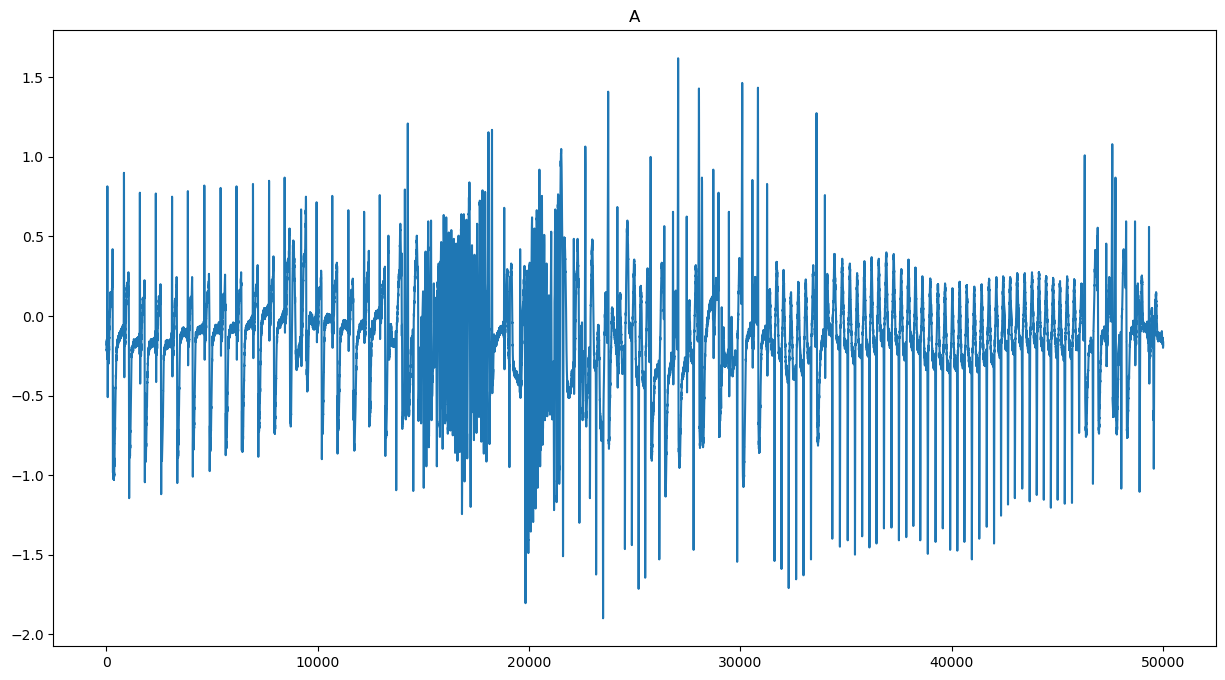

In [230]:
print_signal(ecg_signal[:mox])

signal de longueur: 50000


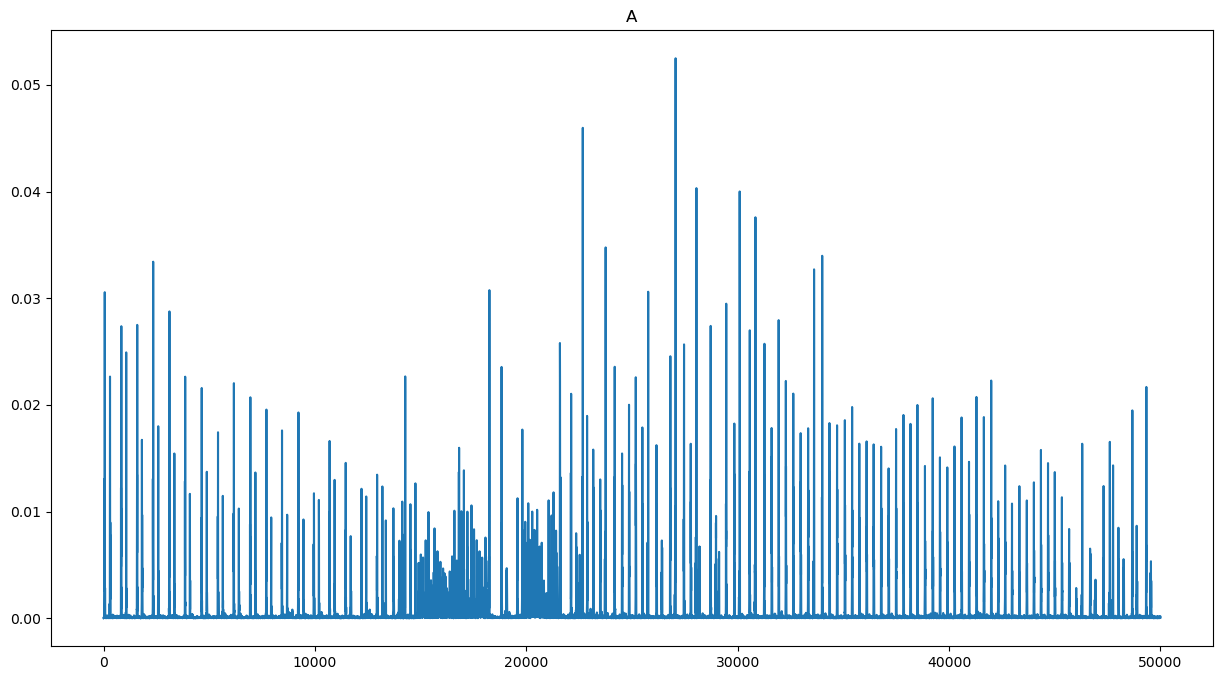

In [234]:
print_signal(h_lisse[:mox])

signal de longueur: 50000


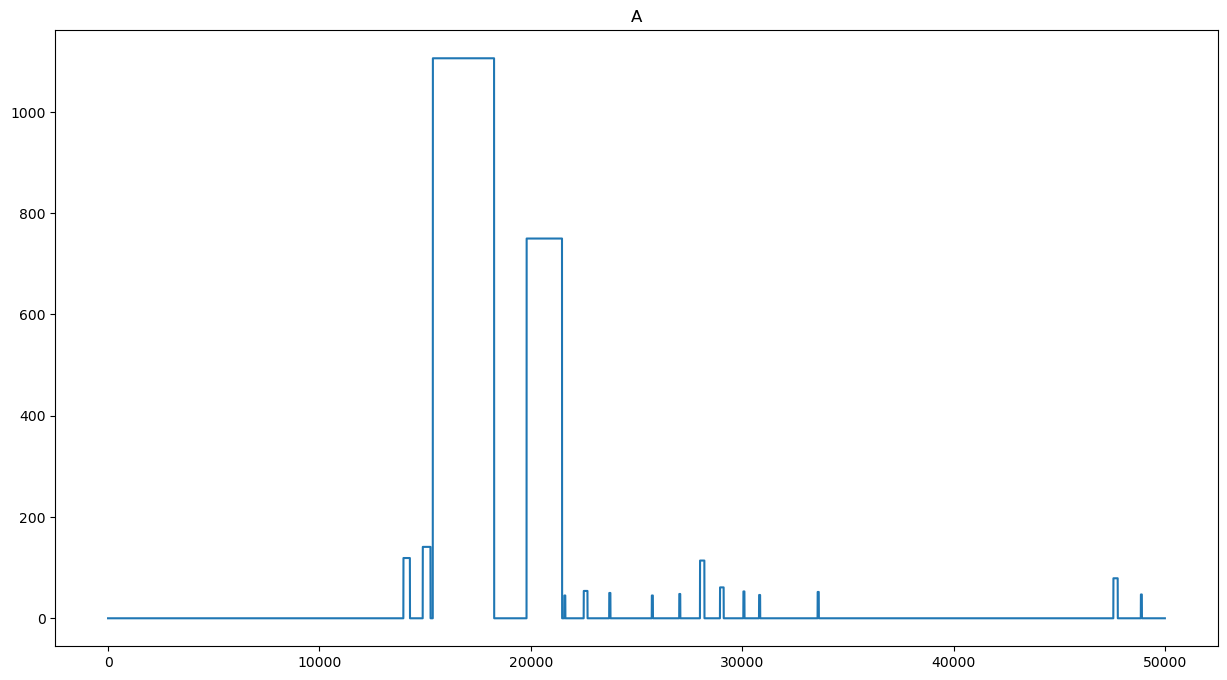

In [232]:
print_signal(taille_groupe)

signal de longueur: 50000


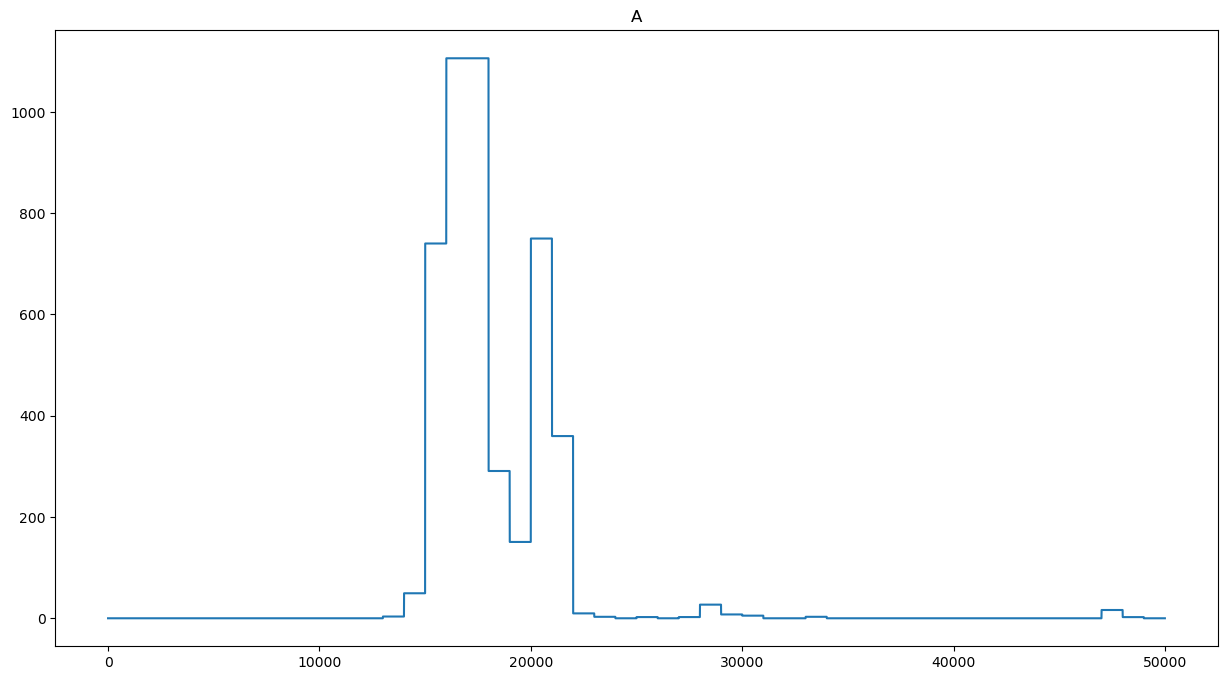

In [233]:
print_signal(moy)